<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Linking overland flow and fluvial erosion

This model is taken from the results presented by Jordan M. Adams et al., 2017, *Geoscientific Model Development*, available <a href="https://orca.cf.ac.uk/99128/7/gmd-10-1645-2017.pdf">here</a>.

It links two Landlab components - *OverlandFlow* and *DetachmentLtdErosion*.
* *OverlandFlow* implements in Landlab the algorithm presented by de Almeida et al., (2012), *Water Resources Research*, available <a href="http://onlinelibrary.wiley.com/doi/10.1029/2011WR011570/full">here</a>.
* *DetachmentLtdErosion* implements a commonly used incision/detachment model, in which removal of material is a power law function of discharge and (in this case) water surface slope. This is a widely applied algorithm in landscape evolution models, such as in Whipple and Tucker (1999), available <a href="http://onlinelibrary.wiley.com/doi/10.1029/1999JB900120/full">here</a>. It is important to note that this component is written to work specifically with the *OverlandFlow* component, and not with steady-state hydrology, as is commonly applied in landscape evolution models.

This example illustrates the importance of watershed shape on hydrograph generation and erosion patterns. This example uses two synthetic landscapes, or landscapes produced using a landscape evolution model. One landscape is square and one is rectangular. In this case the landscapes were produced using steady-state hydrology, or the assumption commonly used in landscape evolution models that discharge is equal to the produce of drainage area and rainfall rate. We use synthetic landscapes simply because it was easier to create watersheds of the same size but different shapes. However, the *OverlandFlow* and *DetachmentLtdErosion* components can be run using DEM data from real watersheds.

* Below we import Landlab components, functions for importing data, numpy and plotting tools.
  * Don't worry about warnings if they come up.

In [1]:
%matplotlib inline 

from landlab.components import OverlandFlow, DetachmentLtdErosion, SinkFiller
from landlab.io import read_esri_ascii
from landlab import imshow_grid
import numpy as np
import copy
from matplotlib import pyplot as plt

* Now we import the data for the watershed we want to run on.
* The user can change the `basin_flag` to be `Square` or `Long` depending on the watershed to run.
  * Discharge is calculated on links, and in this case the outlet link is already known and used for plotting purposes.
* Ths user also chooses which storm to run. 
  * `Base` has an intensity of 5.0 mm/hr, with a duration of 2 hr.
  * `HigherIntensity` has an intensity of 10.0 mm/hr, with a duration of 2 hr.
  * `LongerDuration` has an intensity of 5.0 mm/hr, with a duration of 4 hr.

/Users/marielnelson/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/Users/marielnelson/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


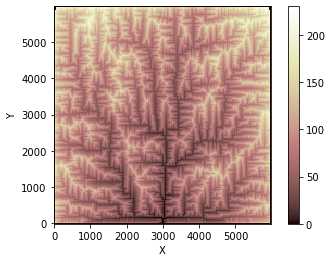

In [2]:
max_dt=0.5  # Using only the default time step calculator gives some unstable results. This low value ensures more stables results use it in seconds
tPlot = 500 # Just to get a plot every this seconds

basin_flag = 'Square' # 'Square' or Long'
storm_flag = 'HigherIntensity' # 'Base' or'HigherIntensity' or 'LongerDuration'

### If the basin flag matches one of the two select basins, the filename and
### the outlet link to sample discharge values from for plotting.

if basin_flag == 'Square':
    watershed_dem = 'Square_TestBasin.asc'
    link_to_sample = 299
    node_to_sample = 300
else:
    watershed_dem = 'Long_TestBasin.asc'
    link_to_sample = 149
    node_to_sample = 150

### Reading in the ESRI ASCII DEM given the filename from above, and setting
### the topographic__elevation field.

(rmg, z) = read_esri_ascii(watershed_dem, name='topographic__elevation')
imshow_grid(rmg,'topographic__elevation',vmin=0)  # plots the DEM
plt.show()

### remembering the initial watershed elevations for plotting purposes later
sf = SinkFiller(rmg, routing='D4', apply_slope=True, fill_slope=1.e-5)
sf.fill_pits()
z_initial = copy.deepcopy(z) 

#rmg.node_at_link_head[149] #NMG REMOVE REMOVE REMOVE!!!

In [3]:
rmg.set_watershed_boundary_condition(z)

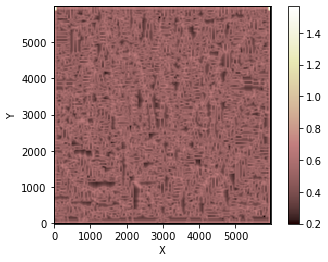

In [4]:
OverlandFlow.input_var_names
DetachmentLtdErosion.input_var_names
rmg.add_zeros('surface_water__depth', at = 'node')      # All cells are dry at the beginning of the simulation
rmg.add_zeros('surface_water__discharge', at='link')    # All cells are dry at the beginning of the simulation - no discharge

# I don't know if these variables are used
rmg['node']['surface_water__discharge'] = np.zeros(rmg.number_of_nodes)
rmg['node']['water_surface__slope'] = np.zeros(rmg.number_of_nodes)

# Also, DetachmentLtdErosion requires the calculation of the 'topographic__slope'
rmg.at_node['topographic__slope'] = rmg.calc_slope_at_node(elevs='topographic__elevation')
imshow_grid(rmg,'topographic__slope');
plt.show()

In [5]:
# Initialization
of = OverlandFlow(rmg, mannings_n=0.03, steep_slopes=True, alpha = 0.3)   # instantiate OverlandFlow object
dle = DetachmentLtdErosion(rmg, K_sp = 1.259162261 * (10**-7)) #instantiate DetachmentLtdErosion object

* Now we set the boundary conditions, instantiate the components, and set the appropriate storm parameters.
  * All `NODATA` nodes in the DEM are closed boundaries and the outlet is set to an open boundary. This is all done in `rmg.set_watershed_boundary_condition(z)`.
 

In [6]:
if storm_flag == 'Base':
    starting_precip_mmhr = 5.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 7200.
elif storm_flag == 'HigherIntensity':
    starting_precip_mmhr = 10.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 7200.
elif storm_flag == 'LongerDuration':
    starting_precip_mmhr = 5.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 14400.

* Before we go further, let's pause to look at the landscape that we will be routing flow over.

* Initialize a few more parameters, and getting ready to run the time loop and save data for plotting.
  * These two components take time steps in *seconds*

In [7]:
uplift_rate = 3.170979 * (10**-10) # m/s

elapsed_time = 1.0
model_run_time = 43200.0 # s

## Lists for saving data
discharge_at_outlet = []
hydrograph_time = []
incision_at_outlet = []

* Let's run the time loop, that is, generate overland flow and erode!

Elapsed time : 500.5  s. Current dt = 0.5  s


/Users/marielnelson/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
  cmap.set_bad(color=color_for_closed)


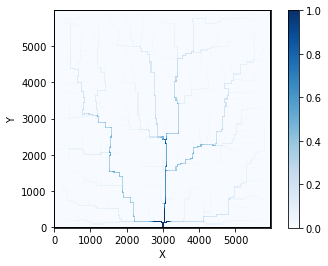

Elapsed time : 1000.5  s. Current dt = 0.5  s


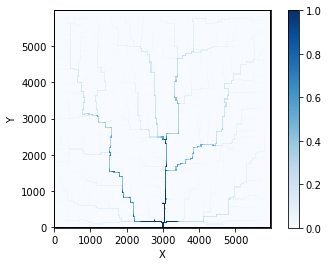

Elapsed time : 1500.5  s. Current dt = 0.5  s


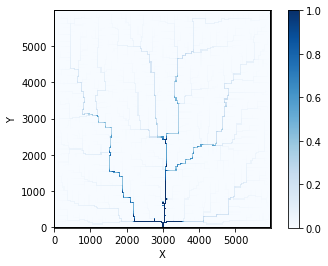

Elapsed time : 2000.5  s. Current dt = 0.5  s


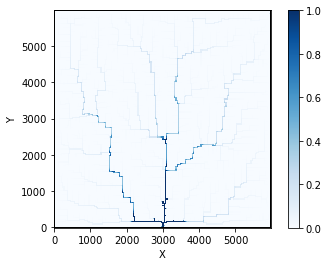

Elapsed time : 2500.5  s. Current dt = 0.5  s


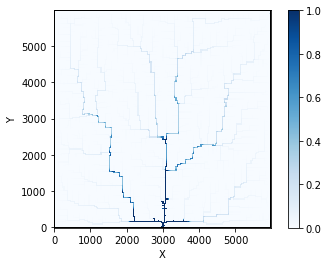

Elapsed time : 3000.5  s. Current dt = 0.5  s


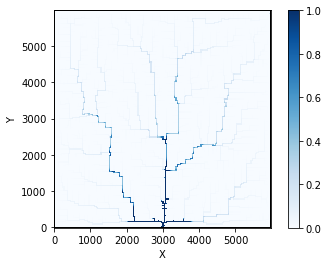

Elapsed time : 3500.5  s. Current dt = 0.5  s


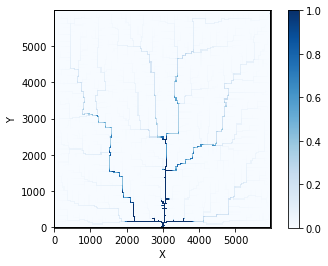

Elapsed time : 4000.5  s. Current dt = 0.5  s


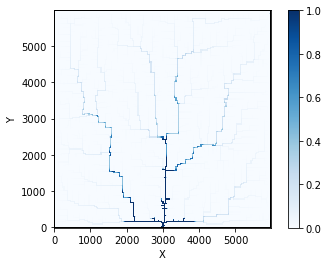

Elapsed time : 4500.5  s. Current dt = 0.5  s


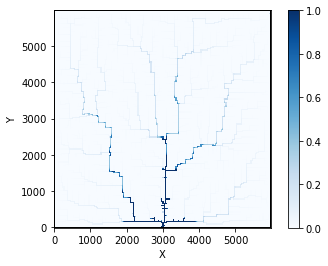

In [ ]:
while elapsed_time < model_run_time:
    # Setting the adaptive time step
    of.dt = min(max_dt,of.calc_time_step())

    ## The storm starts when the model starts. While the elapsed time is less
    ## than the storm duration, we add water to the system as rainfall.
    if elapsed_time < (storm_duration):
        of.rainfall_intensity =  starting_precip_ms  
    else: # elapsed time exceeds the storm duration, rainfall ceases.
        of.rainfall_intensity = 0.0

    of.overland_flow()                      # Generating overland flow based on the deAlmeida solution.
    of.dt = min(max_dt,of.calc_time_step())      # of.overland_flow changes the dt. This is to ensure that we are using the same in both components
    
    ## Mapping water discharge from links (m^2/s) to nodes (m^3/s) for use
    ## in the DetachmentLtdErosion component.
    #node_slope = of.discharge_mapper(rmg['link']['surface_water__discharge'])
   
    ## Mapping water discharge from links (m^2/s) to nodes (m^3/s) for use
    ## in the DetachmentLtdErosion component.
    node_slope = (of._water_surface_slope[rmg.links_at_node] * rmg.active_link_dirs_at_node)
    incision_Q = np.abs(of._q * rmg.dx)[rmg.links_at_node]
    rmg['node']['surface_water__discharge'] = (incision_Q[np.arange(len(node_slope)), np.argmax(node_slope, axis=1)])
   
    ## Calculating water surface slope from the OverlandFlow component.
    node_slope = node_slope.max(axis=1)
    rmg['node']['water_surface__slope'] = node_slope

    ## Eroding topographic__elevation using DetachmentLtdErosion component.
    #dle.erode(of.dt, slope='water_surface__slope')
    dle.run_one_step(of.dt)

    ## Updating topographic__elevation after surface was eroded in
    ## DetachmentLtdErosion component.
    rmg['node']['topographic__elevation'] += uplift_rate * of.dt

    ## Append time and discharge to their lists to save data and for plotting.
    hydrograph_time.append(elapsed_time)
    discharge_at_outlet.append(np.abs(of._q[link_to_sample]) * rmg.dx)
    incision_at_outlet.append(dle._I[node_to_sample])

    ## If one wanted to see the time evolve, uncomment below, but this
    ## produces A LOT of output, as time steps are very short.
    tPlot = tPlot-of.dt
    if tPlot <= 0:
        print('Elapsed time :',elapsed_time,' s. Current dt =',of.dt,' s')
        imshow_grid(rmg, 'surface_water__depth',cmap='Blues',vmin=0,vmax=1);
        plt.show()
       
        #imshow_grid(rmg,'topographic__elevation',vmin=0)  # plots the DEM
        #plt.show()
        tPlot = 500

    ## Updating elapsed_time
    elapsed_time += of.dt

* Let's look at the data.

In [ ]:
## Plotting the hydrograph at the outlet
plt.figure(1)
plt.plot(hydrograph_time, discharge_at_outlet, color='mediumblue')
plt.ylabel('Discharge (cms)')
plt.xlabel('Time (seconds)')
plt.title('Hydrograph at Watershed Outlet')

## Below is if you want to save a figure.
# files=plt.savefig('HydrographAtBasinOutlet.png')

In [ ]:
## Plotting the incision rate through time at the outlet
plt.figure(2)
plt.plot(hydrograph_time, incision_at_outlet, color='darkred')
plt.ylabel('incision rate (m/s)')
plt.xlabel('Time (seconds)')
plt.title('Incision at Watershed Outlet')

## Below is if you want to save a figure.
# files=plt.savefig('HydrographAtBasinOutlet.png')

* Let's look at the change in the topography, first including uplift.
  * The colorbar is limited to beter show patterns.
  * Because we didn't take out uplift, there are some locations in which elevation has actually increased.

In [ ]:
z_diff = z - z_initial # the difference in elevation from start to finish
imshow_grid(rmg, z_diff, limits=(-0.00004, np.max(z_diff)))  

* We can take out uplift in order to just look at incision rates and patterns.
  * We again limit the color bar to highlight patterns

In [ ]:
### this is just fluvial incision, which will be negative
z_diff = z - z_initial - uplift_rate * model_run_time 
imshow_grid(rmg, z_diff, limits=(-0.00004, 0.0))